<a href="https://colab.research.google.com/github/kasparmartens/NeuralDecomposition/blob/master/toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade git+https://github.com/kasparmartens/NeuralDecomposition.git

  Cloning https://github.com/kasparmartens/NeuralDecomposition.git to /private/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/pip-req-build-5h3s0ev1
  Running command git clone --filter=blob:none --quiet https://github.com/kasparmartens/NeuralDecomposition.git /private/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/pip-req-build-5h3s0ev1
  Resolved https://github.com/kasparmartens/NeuralDecomposition.git to commit 42a2a6355ffe8b0a136d72975fbcdab171ac999e
  Preparing metadata (setup.py) ... done
  Created wheel for NeuralDecomposition: filename=NeuralDecomposition-0.1-py3-none-any.whl size=11183 sha256=e7a5d851cb778746e880dd7fc656739f8a393cf2327d5f28a21c88c8ba05d2ee
  Stored in directory: /private/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/pip-ephem-wheel-cache-bksgtrjs/wheels/9d/bd/a1/7250d2e9b505a29133865eeb8e595ff57b68aa404749181448
Successfully built NeuralDecomposition


Necessary imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from ND.encoder import cEncoder
from ND.decoder import Decoder
from ND.CVAE import CVAE
from ND.helpers import expand_grid

from torch.utils.data import TensorDataset, DataLoader

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

Choose device (i.e. CPU or GPU)

In [2]:
device = "cpu"

Generate a synthetic data set (700 data points, 5 features)

In [190]:
N = 700

# generate ground truth latent variable z and covariate c
z = Uniform(-2.0, 2.0).sample((N, 1))
c = Uniform(-2.0, 2.0).sample((N, 1))
noise_sd = 0.05

# generate five features
y1 = torch.exp(-z**2) - 0.2*c
y2 = torch.sin(z) + 0.2*c + 0.7*torch.sin(z)*(z > 0).float()*c
y3 = torch.tanh(z) + 0.2*c
y4 = 0.2*z + torch.tanh(c)
y5 = 0.1*z

Y = torch.cat([y1, y2, y3, y4, y5], dim=1)
Y += noise_sd * torch.randn_like(Y)

Y = (Y - Y.mean(axis=0, keepdim=True)) / Y.std(axis=0, keepdim=True)

data_dim = Y.shape[1]
n_covariates = 1
hidden_dim = 32

For model fitting, we will need a `DataLoader` object

In [191]:
dataset = TensorDataset(Y.to(device), c.to(device))
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

Setting up the CVAE encoder + decoder

In [192]:
### ENCODER

# define encoder which maps (data, covariate) -> (z_mu, z_sigma)
encoder_mapping = nn.Sequential(
    nn.Linear(data_dim + n_covariates, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 2)
)

encoder = cEncoder(z_dim=1, mapping=encoder_mapping)

In [51]:
### DECOMPOSABLE DECODER

# grid needed for quadrature
grid_z = torch.linspace(-2.0, 2.0, steps=15).reshape(-1, 1).to(device)
grid_c = torch.linspace(-2.0, 2.0, steps=15).reshape(-1, 1).to(device)
grid_cz = torch.cat(expand_grid(grid_z, grid_c), dim=1).to(device)

decoder_z = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_c = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_cz = nn.Sequential(
    nn.Linear(2, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder = Decoder(data_dim, 
                  grid_z, grid_c, grid_cz, 
                  decoder_z, decoder_c, decoder_cz,
                  has_feature_level_sparsity=True, p1=0.1, p2=0.1, p3=0.1, 
                  lambda0=1e2, penalty_type="MDMM",
                  device=device)

Combine the encoder + decoder and fit the decomposable CVAE

In [52]:
model = CVAE(encoder, decoder, lr=5e-3, device=device)

loss, integrals = model.optimize(data_loader,
                                 n_iter=15000, 
                                 augmented_lagrangian_lr=0.1)


Fitting Neural Decomposition.
	Data set size 700. # iterations = 15000 (i.e. # epochs <= 1364)

	Iter     0.	Total loss 2064.990
	Iter   500.	Total loss 128.758
	Iter  1000.	Total loss 108.665
	Iter  1500.	Total loss 126.314
	Iter  2000.	Total loss 118.681
	Iter  2500.	Total loss 103.070
	Iter  3000.	Total loss 85.221
	Iter  3500.	Total loss 49.108
	Iter  4000.	Total loss 12.629
	Iter  4500.	Total loss 89.063
	Iter  5000.	Total loss 66.939
	Iter  5500.	Total loss 2.230
	Iter  6000.	Total loss -4.468
	Iter  6500.	Total loss -20.423
	Iter  7000.	Total loss -22.380
	Iter  7500.	Total loss -50.567
	Iter  8000.	Total loss -52.865
	Iter  8500.	Total loss -48.666
	Iter  9000.	Total loss -72.569
	Iter  9500.	Total loss -0.347
	Iter 10000.	Total loss -43.885
	Iter 10500.	Total loss -72.679
	Iter 11000.	Total loss -53.651
	Iter 11500.	Total loss -62.000
	Iter 12000.	Total loss -40.422
	Iter 12500.	Total loss -64.008
	Iter 13000.	Total loss -48.828
	Iter 13500.	Total loss -52.212
	Iter 14000.	Tot

### Diagnostics and interpretation of the model fit

First let's see if the integrals have converged sufficiently close to zero

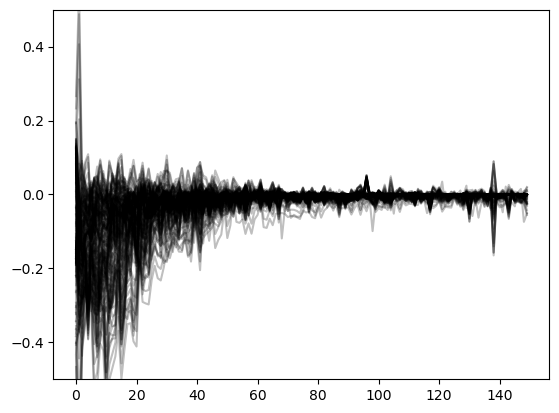

In [53]:
def plot_integrals(integrals):
    n_rep = integrals.shape[0]
    n_iter = integrals.shape[1]
    time = np.arange(n_iter).reshape(-1, 1)
    time_mat = np.tile(time, [1, n_rep])

    plt.plot(time_mat, integrals.T, c="black", alpha=0.25)
    plt.ylim(-0.5, 0.5)

plot_integrals(integrals)

Now let's look at the inferred $z$ values, together with the mappings $z \mapsto \text{features}$

In [54]:
with torch.no_grad():
    # encoding of the entire observed data set
    mu_z, sigma_z = encoder(Y.to(device), c.to(device))
    # predictions from the decoder
    Y_pred = decoder(mu_z, c.to(device))
    Y_error = Y - Y_pred

    # output to CPU
    mu_z, sigma_z = mu_z.cpu(), sigma_z.cpu()
    Y_pred = Y_pred.cpu()
    Y_error = Y_error.cpu()

### Correlation between the ground truth $z$ and the inferred $z$ values

In [55]:
np.cov(Y_pred[:, 0], Y_error[:, 0])

array([[0.98666997, 0.00300468],
       [0.00300468, 0.0073206 ]])

In [56]:
Y_error.var(dim=0, keepdim=True), Y_pred.var(dim=0, keepdim=True), mu_z.shape

(tensor([[0.0073, 0.0025, 0.0045, 0.0055, 0.1447]]),
 tensor([[0.9867, 1.0114, 1.0449, 1.0248, 0.8861]]),
 torch.Size([700, 1]))

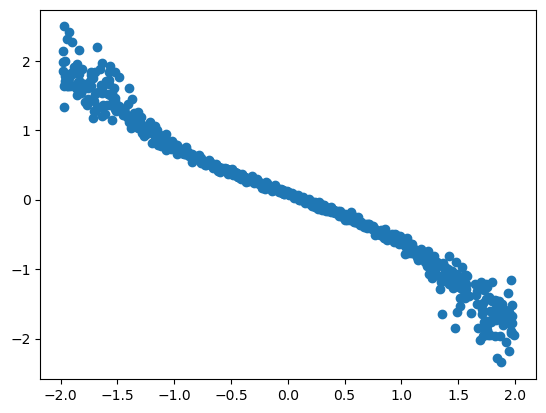

In [57]:
plt.scatter(z, mu_z)

### Visualising mappings from z to feature space

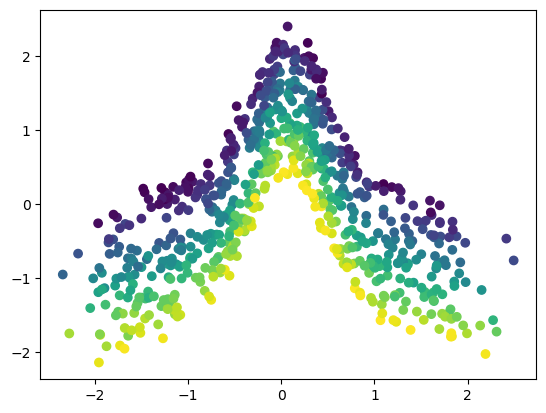

In [58]:
plt.scatter(mu_z, Y[:, 0], c=c.reshape(-1))

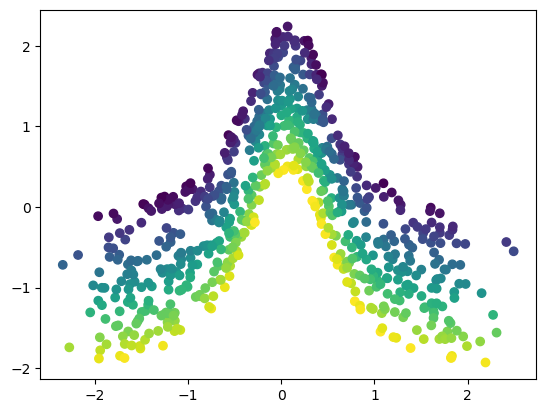

In [59]:
plt.scatter(mu_z, Y_pred[:, 0], c=c.reshape(-1))

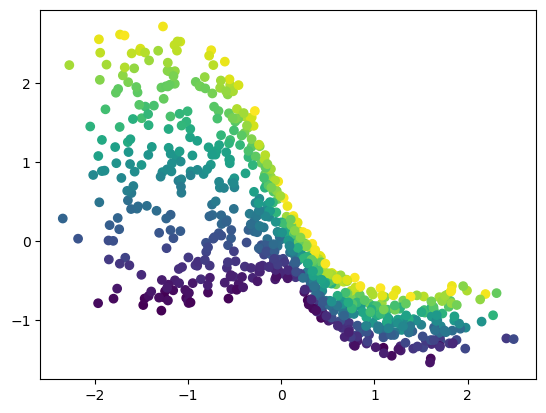

In [60]:
plt.scatter(mu_z, Y[:, 1], c=c.reshape(-1))

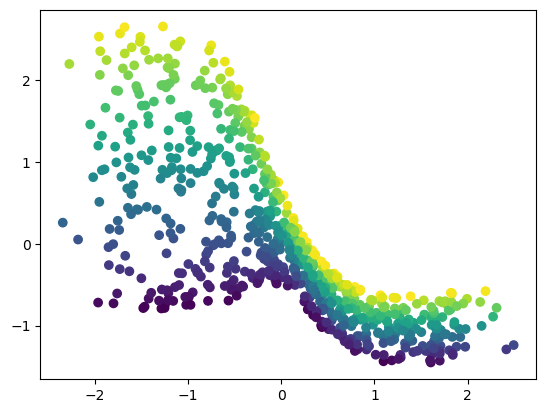

In [61]:
plt.scatter(mu_z, Y_pred[:, 1], c=c.reshape(-1))

### Inferred sparsity masks

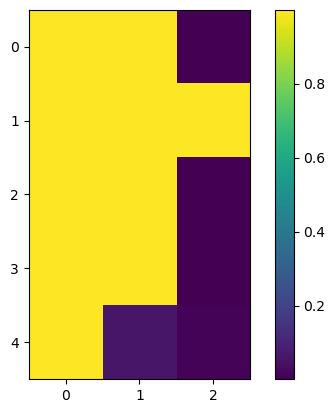

In [62]:
with torch.no_grad():
    sparsity = decoder.get_feature_level_sparsity_probs().cpu()
    
plt.imshow(sparsity)
plt.colorbar()

In [63]:
a_no_error = decoder.fraction_of_variance_explained(mu_z, c)

In [64]:
a_error = decoder.fraction_of_variance_explained(mu_z, c, Y_error=Y_error)

In [28]:
[f'{s:.2}' for s in a_no_error[0]], [f'{s:.2}' for s in a_error[0]], [f'{s/sum(a_error[0][:3]):.2}' for s in a_error[0][:3]]

(['0.72', '0.28', '7.1e-29'],
 ['0.63', '0.25', '3.4e-32', '0.12'],
 ['0.72', '0.28', '3.9e-32'])

In [47]:
[f'{s:.2}' for s in a_no_error[0]], [f'{s:.2}' for s in a_error[0]], [f'{s/sum(a_error[0][:3]):.2}' for s in a_error[0][:3]]

(['0.04', '0.96', '8.8e-18'],
 ['2.3e-17', '0.13', '1.2e-07', '0.87'],
 ['1.7e-16', '1.0', '9e-07'])

In [65]:
[f'{s:.2}' for s in a_no_error[0]], [f'{s:.2}' for s in a_error[0]], [f'{s/sum(a_error[0][:3]):.2}' for s in a_error[0][:3]]

(['0.71', '0.29', '1.5e-35'],
 ['0.7', '0.29', '2e-39', '0.0072'],
 ['0.71', '0.29', '2e-39'])

In [66]:
[f'{s:.2}' for s in a_no_error[-1]], [f'{s:.2}' for s in a_error[-1]], [f'{s/sum(a_error[-1][:3]):.2}' for s in a_error[-1][:3]]

(['1.0', '9.6e-09', '1.2e-19'],
 ['0.86', '2.7e-21', '3.2e-12', '0.14'],
 ['1.0', '3.1e-21', '3.7e-12'])

# Trying on MATRIX data

In [236]:
!pip install scipy

  Using cached scipy-1.14.1-cp310-cp310-macosx_14_0_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp310-cp310-macosx_14_0_x86_64.whl (25.5 MB)


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import os
from openpyxl import load_workbook  # To read Excel file

# CLR Transformation
def clr_transform(df):
    # Ensure there are no zeros in the data
    df = df.replace(0, np.nan).fillna(1e-04)
    
    def generalized_log_transform(x, constant=1):
        return np.log(x + np.sqrt(x**2 + constant**2))
    
    # Apply generalized log transform
    glr_df = df.apply(generalized_log_transform, axis=1)
    
    # Apply CLR transformation
    clr_df = df.apply(lambda row: np.log(row) - np.mean(np.log(row)), axis=1)
    
    return pd.DataFrame(clr_df), pd.DataFrame(glr_df)

# Median Normalization
def median_normalization(block):
    medians = block.median(axis=0, skipna=True)
    normalized_df = block.divide(medians, axis=1)
    return normalized_df

# Square Root Transformation
def sqrt_transform(block):
    return block.applymap(np.sqrt)

# Pareto Scaling
def pareto_scale(x):
    return (x - np.mean(x)) / np.sqrt(np.std(x))

# Block Scaling by Variance
def block_scale_by_variance(block):
    return block / np.sqrt(block.var(axis=0, skipna=True).sum())

# Process Block
def process_block(df):
    # df = df.apply(pd.to_numeric, errors='coerce')  # Convert all values to numeric
    df = df.apply(pareto_scale, axis=0)  # Apply Pareto scaling
    # df = block_scale_by_variance(df)  # Scale by variance
    return df

# File Path
file_path = "~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx"

# Read all sheet names
sheet_names = pd.ExcelFile(file_path).sheet_names

results = {}

# Process each sheet
for sheet in sheet_names:
    if sheet != "Factors":
        data = pd.read_excel(file_path, sheet_name=sheet)
        if sheet == "OTUs":
            clr_df, glr_df = clr_transform(data)
            results[sheet] = process_block(clr_df)
        else:
            data = median_normalization(data)
            # data = sqrt_transform(data)
            results[sheet] = process_block(pd.DataFrame(data))

# Combine results into a single matrix
result_matrix = pd.concat(results.values(), axis=1)

# Save the result to a new Excel file if needed
# output_file = "processed_results.xlsx"
# result_matrix.to_excel(output_file, index=False)


In [18]:
result_matrix.to_csv('data/normalized_features_82_samples.csv', index=None)

In [4]:
from ND.decoder_multiple_covariates import Decoder_multiple_covariates
from ND.CVAE_multiple_covariates import CVAE_multiple_covariates

In [5]:
df_factors = pd.read_excel("~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx", sheet_name='LIP_TS_NEG')
df_factors_otu = pd.read_excel("~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx", sheet_name='OTUs')

In [6]:
df_cov = pd.read_excel("~/Documents/data_integration/data/MATRIX_TS_blocks.xlsx", sheet_name='Factors')

In [7]:
# result_matrix = result_matrix[[c for c in list(df_factors.columns) + list(df_factors_otu.columns)]]

In [8]:
# Y = df_factors.to_numpy()
# row_sums = Y.sum(axis=1, keepdims=True)
# Y = Y / row_sums

# Y = generalized_log_transform(Y, a=1)

In [9]:
df_cov

,Time,Plot,Cultivar,Fungicide
0,140722,9,Kvium,Sprayed (S)
1,280622,21,Heerup,Sprayed (S)
2,140722,10,Heerup,Unsprayed (UN)
3,140722,17,Heerup,Sprayed (S)
4,280622,20,Heerup,Unsprayed (UN)
...,...,...,...,...
77,280622,22,Kvium,Sprayed (S)
78,280622,8,Rembrandt,Sprayed (S)
79,140722,18,Kvium,Sprayed (S)
80,160622,20,Heerup,Unsprayed (UN)


In [10]:
Y = result_matrix.to_numpy()
Y = torch.Tensor(Y)

In [11]:
c = torch.Tensor([pd.factorize(df_cov[c])[0] for c in df_cov.columns]).T

/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_41680/4096655918.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_290u7eqnqq/croot/pytorch-select_1730848721858/work/torch/csrc/utils/tensor_new.cpp:277.)
  c = torch.Tensor([pd.factorize(df_cov[c])[0] for c in df_cov.columns]).T


In [12]:
time = pd.factorize(df_cov['Time'])[0]

In [21]:
c.shape, Y.shape

(torch.Size([82, 4]), torch.Size([82, 8118]))

In [22]:
# Y = torch.Tensor(Y)[:, np.random.randint(Y.shape[1], size=(100,))]

In [23]:
# Y.shape

In [24]:
data_dim = Y.shape[1]
n_covariates = c.shape[1]
hidden_dim = 128
z_dim = 1

In [25]:
dataset = TensorDataset(Y.to(device), c.to(device))
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

In [31]:
### ENCODER

# define encoder which maps (data, covariate) -> (z_mu, z_sigma)
encoder_mapping = nn.Sequential(
    nn.Linear(data_dim + n_covariates, hidden_dim),
    # nn.Linear(data_dim, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 2*z_dim)
)

encoder = cEncoder(z_dim=z_dim, mapping=encoder_mapping)

In [32]:
### DECOMPOSABLE DECODER

lim_val = 2.0
steps = 15
# grid needed for quadrature
grid_z = torch.linspace(-lim_val, lim_val, steps=steps).reshape(-1, 1).to(device)
# grid_z = torch.cat(expand_grid(grid_z, grid_z), dim=1).to(device)
grid_cov = torch.linspace(-lim_val, lim_val, steps=steps).reshape(-1, 1).to(device)
grid_c = [grid_cov for _ in range(n_covariates)]
# grid_cz = [torch.cat(expand_grid(grid_z, gr), dim=1).to(device) for gr in grid_c]

decoder_z = nn.Sequential(
    nn.Linear(z_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_c = nn.Sequential(
    nn.Linear(1, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder_cz = nn.Sequential(
    nn.Linear(1 + z_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, data_dim)
)

decoder = Decoder_multiple_covariates(data_dim, n_covariates,
                  grid_z, grid_c, 
                  decoder_z, [decoder_c for _ in range(n_covariates)], [decoder_cz for _ in range(n_covariates)],
                  has_feature_level_sparsity=True, p1=0.1, p2=0.1, p3=0.1, 
                  lambda0=1e3, penalty_type="MDMM",
                  device=device)

In [33]:
encoder, decoder

(cEncoder(
   (mapping): Sequential(
     (0): Linear(in_features=8122, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=2, bias=True)
   )
 ),
 Decoder_multiple_covariates(
   (mapping_z): Sequential(
     (0): Linear(in_features=1, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=8118, bias=True)
   )
 ))

In [38]:
model = CVAE_multiple_covariates(encoder, decoder, lr=5e-4, device=device)

loss, integrals = model.optimize(data_loader,
                                 n_iter=500, 
                                 augmented_lagrangian_lr=0.1)


Fitting Neural Decomposition.
	Data set size 82. # iterations = 500 (i.e. # epochs <= 250)

	Iter     0.	Total loss 2344016.250


In [40]:
len(integrals[:, -1])

1014750

In [41]:
len((abs(integrals[:, -1]) < 0.2).nonzero()[0]) / len(integrals)

0.631430401576743

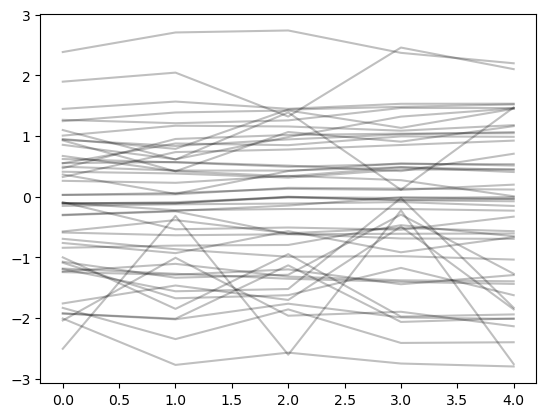

In [46]:
def plot_integrals(integrals):
    n_rep = integrals.shape[0]
    n_iter = integrals.shape[1]
    time = np.arange(n_iter).reshape(-1, 1)
    time_mat = np.tile(time, [1, n_rep])
    plt.plot(time_mat, integrals.T, c="black", alpha=0.25)

plot_integrals(integrals[:50])

In [47]:
with torch.no_grad():
    # encoding of the entire observed data set
    mu_z, sigma_z = encoder(Y.to(device), c.to(device))
    # predictions from the decoder
    Y_pred = decoder(mu_z, c.to(device))
    Y_error = Y - Y_pred

    Y_pred_z = decoder_z(mu_z)
    Y_pred_c = decoder_c(c.to(device))
    Y_pred_zc = decoder_cz(torch.cat([mu_z, c.to(device)], dim=1))

    # output to CPU
    mu_z, sigma_z = mu_z.cpu(), sigma_z.cpu()
    Y_pred = Y_pred.cpu()
    Y_error = Y_error.cpu()
    Y_pred_z = Y_pred_z.cpu()
    Y_pred_c = Y_pred_c.cpu()
    Y_pred_zc = Y_pred_zc.cpu()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (82x4 and 1x128)

In [49]:
varexp = decoder.fraction_of_variance_explained(mu_z, c, Y_error=Y_error)

In [50]:
varexp.shape

torch.Size([8118, 10])

In [213]:
time_map = {0: 'Day 4: 14-07-22', 1: 'Day 3: 28-06-22', 2: 'Day 1: 16-06-22', 3: 'Day 2: 21-06-22'}

In [214]:
time.shape, mu_z.squeeze(-1).shape

((82,), torch.Size([82]))

In [215]:
df = pd.DataFrame({'mu_z': mu_z.squeeze(-1), 'time': [time_map[t] for t in time]})

/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_23164/568823276.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


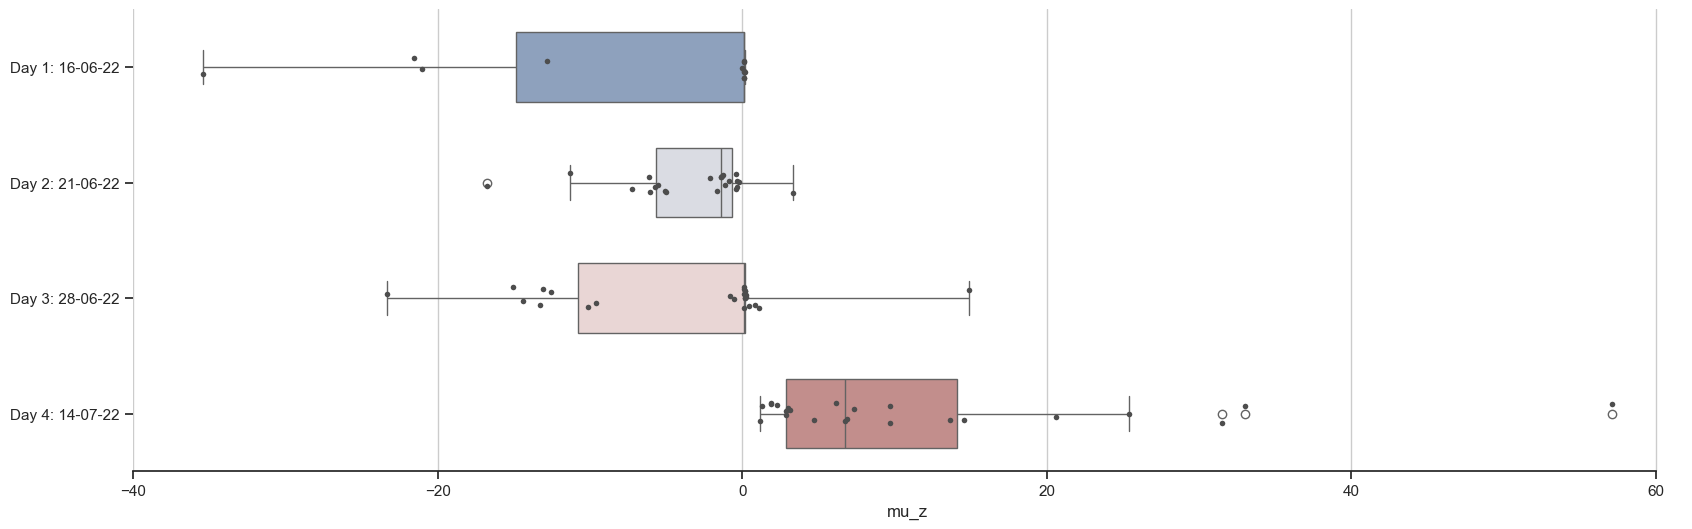

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(20, 6))
# ax.set_xscale("log")

planets = df
custom_order = ['Day 1: 16-06-22', 'Day 2: 21-06-22', 'Day 3: 28-06-22', 'Day 4: 14-07-22']
sns.boxplot(
    planets, x="mu_z", y="time", width=.6, palette="vlag", order=custom_order
)

sns.stripplot(planets, x="mu_z", y="time", size=4, color=".3")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_23164/229382612.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_23164/229382612.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(
/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_23164/229382612.py:34: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_23164/229382612.py:34: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyl

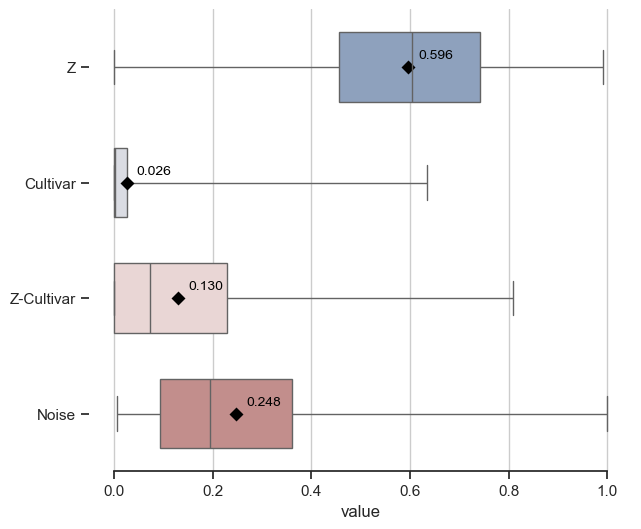

In [217]:
# Example tensor (replace with your actual data)
data = varexp  # Example tensor with random values

# Step 1: Flatten the tensor
flattened = data.reshape(-1)  # Shape becomes [8118 * 8,]

# Step 2: Create column names
# column_names = ['Z', 'Plot', 'Cultivar', 'Fungicide', 'Z-Plot', 'Z-Cultivar', 'Z-Fungicide', 'Noise']
# column_names = ['Z', 'Time', 'Plot', 'Cultivar', 'Fungicide', 'Z-Time', 'Z-Plot', 'Z-Cultivar', 'Z-Fungicide', 'Noise']
column_names = ['Z', 'Cultivar', 'Z-Cultivar', 'Noise']

# Repeat column names for each row
labels = column_names * 8118  # Repeat 8118 times

# Step 3: Create the DataFrame
df = pd.DataFrame({
    'value': flattened.numpy(),  # Convert tensor to NumPy array
    'column': labels
})

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

planets = df
# custom_order = ['Z', 'Time', 'Z-Time', 'Plot', 'Z-Plot', 'Cultivar', 'Z-Cultivar', 'Fungicide', 'Z-Fungicide', 'Noise']
custom_order = ['Z', 'Cultivar', 'Z-Cultivar', 'Noise']
sns.boxplot(
    planets, x="value", y="column",
    whis=[0, 100], width=.6, palette="vlag", order=custom_order
)

# Add means using a point plot
sns.pointplot(
    data=df, x="value", y="column",
    join=False, order=custom_order, 
    ci=None, color="black", markers="D", scale=1
)
means = df.groupby('column')['value'].mean()
# Add text labels for means
for i, column in enumerate(custom_order):
    mean_value = means[column]
    ax.text(
        mean_value+0.02, i-0.1,  # Position: (x, y)
        f'{mean_value:.3f}',  # Format text to 2 decimal places
        color="black", ha="left", va="center", fontsize=10
    )

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [218]:
with torch.no_grad():
    sparsity = decoder.get_feature_level_sparsity_probs().cpu()

# plt.figure(figsize=(10, 40))
# plt.imshow(sparsity[:100])
# plt.colorbar()

In [219]:
Y_pred_z.shape

torch.Size([82, 8118])

In [52]:
torch.argmax(varexp[:, 0])

tensor(7829)

In [43]:
max_index = torch.argmax(varexp[:, 0])


NameError: name 'varexp' is not defined

In [48]:
with torch.no_grad():
    # encoding of the entire observed data set
    mu_z, sigma_z = encoder(Y.to(device), c.to(device))
    # predictions from the decoder
    Y_pred = decoder(mu_z, c.to(device))
    Y_error = Y - Y_pred

    min_z, max_z = mu_z.min(), mu_z.max()
    num_points = 100  # Number of points in the linear space
    z_linear_space = torch.linspace(min_z, max_z, num_points)
    z_linear_space = z_linear_space.view(-1, 1)  # Reshape to (num_points, 1) for a single latent dimension

    col1 = torch.full((100, 1), 0.0)  # Column of zeros
    col2 = torch.full((100, 1), 1.0)  # Column of ones
    col3 = torch.full((100, 1), 2.0)  # Column of twos
    
    # Combine columns into a single tensor
    c_linear_space_0 = torch.cat((col1, col2, col3), dim=1)
    
    # Use the linear space with the decoder
    Y_pred_z = decoder_z(z_linear_space)
    
    Y_pred_c0 = decoder_c(col1.to(device))
    Y_pred_c1 = decoder_c(col2.to(device))
    Y_pred_c2 = decoder_c(col3.to(device))
    
    Y_pred_zc0 = decoder_cz(torch.cat([z_linear_space, col1.to(device)], dim=1))
    Y_pred_zc1 = decoder_cz(torch.cat([z_linear_space, col2.to(device)], dim=1))
    Y_pred_zc2 = decoder_cz(torch.cat([z_linear_space, col3.to(device)], dim=1))

    Y_pred0 = decoder(z_linear_space, col1.to(device))
    Y_pred1 = decoder(z_linear_space, col2.to(device))
    Y_pred2 = decoder(z_linear_space, col3.to(device))

    # output to CPU
    mu_z, sigma_z = mu_z.cpu(), sigma_z.cpu()
    Y_pred = Y_pred.cpu()
    Y_error = Y_error.cpu()
    Y_pred_z = Y_pred_z.cpu()
    Y_pred_c = Y_pred_c.cpu()
    Y_pred_zc = Y_pred_zc.cpu()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x0 and 1x128)

In [239]:
c.shape

torch.Size([82, 1])

In [55]:
pd.factorize(df_cov['Time'])

(array([0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 3, 0, 1, 2, 1, 1, 0, 0,
        1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0,
        0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 2, 2]),
 Index([140722, 280622, 160622, 210622], dtype='int64'))

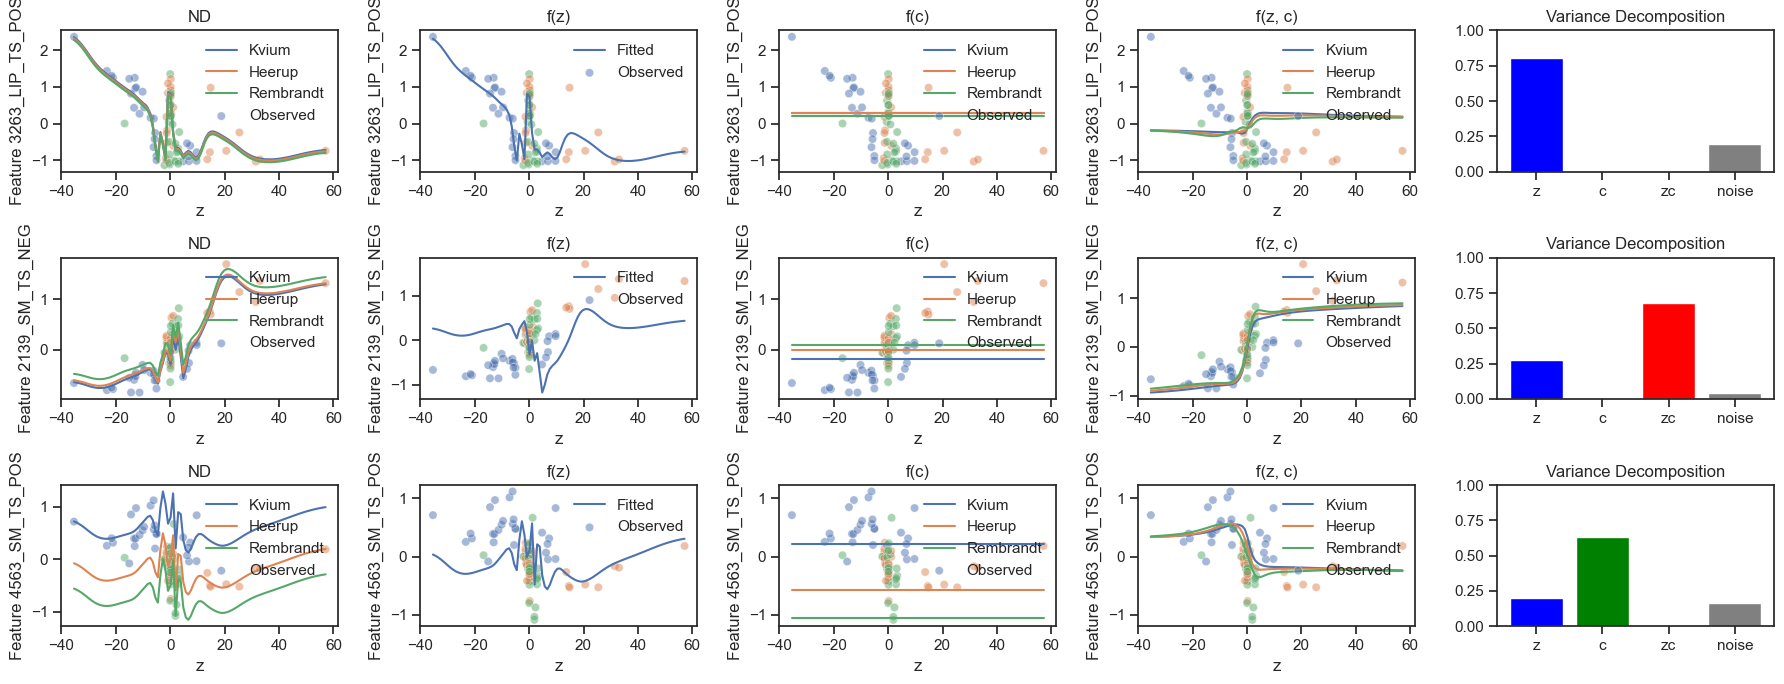

In [240]:
genes = [4, 6629, 3441]  # Example gene indices (adjust based on your data)
conditions = [0, 1, 2]  # Example conditions

pal = sns.color_palette()[:3]
labels = ['Kvium', 'Heerup', 'Rembrandt']

# Create the plot grid
fig, axes = plt.subplots(len(genes), 5, figsize=(6*len(genes), 7))

for a, i in enumerate(genes):
    # ND plot
    conds = [Y_pred0, Y_pred1, Y_pred2]
    for condition, label, color in zip([0, 1, 2], labels, pal):
        sns.lineplot(
            ax=axes[a, 0],
            x=z_linear_space[:, 0],
            y=conds[condition][:, i],  # Select points corresponding to the condition
            color=color,
            label=label  # Add label for the legend
        )
    # sns.lineplot(ax=axes[a, 0], x=mu_z[:, 0], y=Y_pred[:, i], hue=c[:, 0], legend=False, palette=pal, label="Prediction")
    sns.scatterplot(ax=axes[a, 0], x=mu_z[:, 0], y=Y[:, i], hue=c[:, 0], legend=False, alpha=0.5, palette=pal, label="Observed")
    axes[a, 0].set_title("ND")
    axes[a, 0].set_ylabel(f"Feature {result_matrix.columns[i]}")
    axes[a, 0].set_xlabel("z")

    # f(z) plot
    sns.lineplot(ax=axes[a, 1], x=z_linear_space[:, 0], y=Y_pred_z[:, i], legend=False, label="Fitted")
    sns.scatterplot(ax=axes[a, 1], x=mu_z[:, 0], y=Y[:, i], hue=c[:, 0], legend=False, palette=pal, alpha=0.5, label="Observed")
    axes[a, 1].set_title("f(z)")
    axes[a, 1].set_ylabel(f"Feature {result_matrix.columns[i]}")
    axes[a, 1].set_xlabel("z")

    # f(c) plot
    # for cond in conditions:
    #     sns.lineplot(ax=axes[a, 1], x=z_linear_space[:, 0], y=[float(Y_pred_c[cond, 0])*, legend=False, alpha=0.7, label="Prediction")
    # Add multiple lines with different labels
    conds = [Y_pred_c0, Y_pred_c1, Y_pred_c2]
    for condition, label, color in zip([0, 1, 2], labels, pal):
        sns.lineplot(
            ax=axes[a, 2],
            x=z_linear_space[:, 0],
            y=conds[condition][:, i],  # Select points corresponding to the condition
            color=color,
            label=label  # Add label for the legend
        )
    sns.scatterplot(ax=axes[a, 2], x=mu_z[:, 0], y=Y[:, i], hue=c[:, 0], legend=False, alpha=0.5, palette=pal, label="Observed")
    axes[a, 2].set_title("f(c)")
    axes[a, 2].set_ylabel(f"Feature {result_matrix.columns[i]}")
    axes[a, 2].set_xlabel("z")

    # f(z, c) plot
    conds = [Y_pred_zc0, Y_pred_zc1, Y_pred_zc2]
    for condition, label, color in zip([0, 1, 2], labels, pal):
        sns.lineplot(
            ax=axes[a, 3],
            x=z_linear_space[:, 0],
            y=conds[condition][:, i],  # Select points corresponding to the condition
            color=color,
            label=label  # Add label for the legend
        )
    sns.scatterplot(ax=axes[a, 3], x=mu_z[:, 0], y=Y[:, i], hue=c[:, 0], legend=False, palette=pal, alpha=0.5, label="Observed")
    axes[a, 3].set_title("f(z, c)")
    axes[a, 3].set_ylabel(f"Feature {result_matrix.columns[i]}")
    axes[a, 3].set_xlabel("z")
    
    # Variance decomposition bar plot
    axes[a, 4].bar(["z", "c", "zc", "noise"], [varexp[i, 0], varexp[i, 1], varexp[i, 2], varexp[i, 3]], color=["blue", "green", "red", "grey"])
    axes[a, 4].set_title("Variance Decomposition")
    axes[a, 4].set_ylim(0, 1)
    
    for ax in axes[a, :4]:
        ax.legend(title="", loc="upper right", frameon=False)

plt.tight_layout()
plt.show()


In [58]:
import seaborn as sns
pal = sns.color_palette()

In [61]:
pal + pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.89